## House Prices: EDA to ML (Beginner)

**Data Description**

This is a detailed description of the 79 features and their entries, quite important for this prediction

**The notebook is organized as follows:**

* **[Part 0: Imports, Settings and switches, Global functions](#Part-0-:-Imports,-Settings,-Functions)**  
import libraries  
settings for number of cross validations  
define functions that are used often

* **[Part 1: Exploratory Data Analysis](#Part-1:-Exploratory-Data-Analysis)**  
1.1 Get an overview of the features (numerical and categorical) and first look on the target variable SalePrice  
[shape, info, head and describe](#shape,-info,-head-and-describe)  
[Distribution of the target variable SalePrice](#The-target-variable-:-Distribution-of-SalePrice)  
[Numerical and Categorical features](#Numerical-and-Categorical-features)  
[List of features with missing values](#List-of-features-with-missing-values) and Filling missing values  
[log transform](#log-transform)  
1.2 Relation of all features to target SalePrice  
[Seaborn regression plots for numerical features](#Plots-of-relation-to-target-for-all-numerical-features)  
[List of numerical features and their correlation coefficient to target](#List-of-numerical-features-and-their-correlation-coefficient-to-target)  
[Seaborn boxplots for categorical features](#Relation-to-SalePrice-for-all-categorical-features)  
[List of categorical features and their unique values](#List-of-categorical-features-and-their-unique-values)  
1.3 Determine the columns that show strong correlation to target  
[Correlation matrix 1](#Correlation-matrix-1) : all numerical features  
Determine features with largest correlation to SalePrice_Log


* **[Part 2: Data wrangling](#Part-2:-Data-wrangling)**  
[Dropping all columns with weak correlation to SalePrice](#Dropping-all-columns-with-weak-correlation-to-SalePrice)  
[Convert categorical columns to numerical](#Convert-categorical-columns-to-numerical)  
[Checking correlation to SalePrice for the new numerical columns](#Checking-correlation-to-SalePrice-for-the-new-numerical-columns)  
use only features with strong correlation to target  
[Correlation Matrix 2 (including converted categorical columns)](#Correlation-Matrix-2-:-All-features-with-strong-correlation-to-SalePrice)  
create datasets for ML algorithms  
One Hot Encoder  
[StandardScaler](#StandardScaler)

* **[Part 3: Scikit-learn basic regression models and comparison of results](#Part-3:-Scikit-learn-basic-regression-models-and-comparison-of-results)**  
implement GridsearchCV with RMSE metric for Hyperparameter tuning  
for these models from sklearn:  
[Linear Regression](#Linear-Regression)  
[Ridge](#Ridge)  
[Lasso](#Lasso)  
[Elastic Net](#Elastic-Net)  
[Stochastic Gradient Descent](#SGDRegressor)  
[DecisionTreeRegressor](#DecisionTreeRegressor)  
[Random Forest Regressor](#RandomForestRegressor)  
[KNN Regressor](#KNN-Regressor)  
baed on RMSE metric, compare performance of the regressors with their optimized parameters,  
then explore correlation of the predictions and make submission with mean of best models  
Comparison plot: [RMSE of all models](#Comparison-plot:-RMSE-of-all-models)  
[Correlation of model results](#Correlation-of-model-results)  
Mean of best models


Note on scores:  
Submissions are evaluated on Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sales price. (Taking logs means that errors in predicting expensive houses and cheap houses will affect the result equally.)

# Part 0: Imports, Settings, Functions

**Imports**

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
%matplotlib inline
sns.set()

import warnings
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=DeprecationWarning)

**Settings and Switches**

**Here one can choose settings for optional performance and runtime. For example, nr_cv sets the number of cross validation used in GridsearchCV, and min_var_corr is the minimum value for the correlation coefficient to the target (only features with larger correlation will be used).**

In [2]:
# setting the number of cross validation used in the Model part
nr_cv = 5

# switch for using log values for SalePrice and features
use_logvals = 1

#target used for correlation
target = 'SalePrice_Log'

# only columns with correlation above this threshold value
# are used for the ML Regressor in Part 3
min_val_corr = 0.4

# switch for dropping columns that are similar to others already used
drop_similar = 1

**Some useful function**

In [3]:
def get_best_score(grid):
    best_score = np.sqrt(-grid.best_score_)
    print(best_score)
    print(grid.best_params_)
    print(grid.best_estimator_)
    return best_score

In [4]:
def print_cols_large_corr(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()
    print(corr_abs.nlargest(nr_c, targ)[targ])

In [5]:
def plot_corr_matrix(df, nr_c, targ):

    corr = df.corr()
    corr_abs = corr_abs()
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)

    plt.figure(figsize=(nr_c/1.5, nr_c/1.5))
    sns.set(font_scale=1.25)
    sns.heatmap(cm, linewidths=1.5, annot=True, square=True,
                fmt='.2f', annot_kws={'size': 10},
                yticklabels=cols.values, xticklabels=cols.values)
    
    plt.show()

**Load Data**

In [6]:
df_train = pd.read_csv('house_price_train.csv')
df_test = pd.read_csv('house_price_test.csv')

# Part 1: Exploratory Data Analysis

## 1.1 Overview of Features and Relation to target

Let's get a first overview of the train and test dataset. <br>
How many rows and columns are there? <br>
What are the names of the features (columns)? <br>
Which features are numerical, which are categorical? <br>
How many values are missing? <br>
The **shape** and **info** methods answer these questions <br>
**Head** displays some rows of the dataset
**Describe** gives a summary of the statistics (only for numerical columns).

### shape, info, head and describe

In [7]:
print(df_train.shape)
print('-'*50)
print(df_test.shape)

(1460, 81)
--------------------------------------------------
(1459, 80)


In [8]:
print(df_train.info())
print('-'*50)
print(df_test.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

df train has 81 columns (79 features + id and target SalePrice) and 1460 entries (number of rows or house sales) <br>
df test has 80 columns (79 features + id) and 1459 entries <br>
There is lots of info that is probably related to the SalePrice like the area, the neighborhood, the condition and quality. <br>
Maybe other features are not so important for predicting the target, also there might be a strong correlation for some of the features (like GarageCars and GarageArea). For some columns many values are missing: only 7 values for Pool QC in df train and 3 in df test.

In [9]:
df_train.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [10]:
df_train.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,...,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,...,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,...,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,...,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,...,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,...,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


In [11]:
df_test.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal


In [12]:
df_test.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold
count,1459.000000,1459.000000,1232.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1444.000000,1458.000000,...,1458.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000,1459.000000
mean,2190.000000,57.378341,68.580357,9819.161069,6.078821,5.553804,1971.357779,1983.662783,100.709141,439.203704,...,472.768861,93.174777,48.313914,24.243317,1.794380,17.064428,1.744345,58.167923,6.104181,2007.769705
std,421.321334,42.746880,22.376841,4955.517327,1.436812,1.113740,30.390071,21.130467,177.625900,455.268042,...,217.048611,127.744882,68.883364,67.227765,20.207842,56.609763,30.491646,630.806978,2.722432,1.301740
min,1461.000000,20.000000,21.000000,1470.000000,1.000000,1.000000,1879.000000,1950.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000
25%,1825.500000,20.000000,58.000000,7391.000000,5.000000,5.000000,1953.000000,1963.000000,0.000000,0.000000,...,318.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.000000,2007.000000
50%,2190.000000,50.000000,67.000000,9399.000000,6.000000,5.000000,1973.000000,1992.000000,0.000000,350.500000,...,480.000000,0.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000
75%,2554.500000,70.000000,80.000000,11517.500000,7.000000,6.000000,2001.000000,2004.000000,164.000000,753.500000,...,576.000000,168.000000,72.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000
max,2919.000000,190.000000,200.000000,56600.000000,10.000000,9.000000,2010.000000,2010.000000,1290.000000,4010.000000,...,1488.000000,1424.000000,742.000000,1012.000000,360.000000,576.000000,800.000000,17000.000000,12.000000,2010.000000


### The target variable: Distribution of SalePrice

C:\Users\cW\AppData\Local\Temp\ipykernel_17828\158056272.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['SalePrice']);


Skewness: 1.882876
Kurtosis: 6.536282


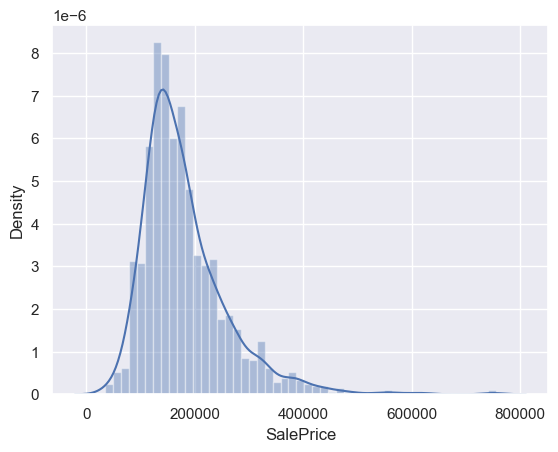

In [13]:
sns.distplot(df_train['SalePrice']);
# skewness and kurtosis
print('Skewness: %f' % df_train['SalePrice'].skew())
print('Kurtosis: %f' % df_train['SalePrice'].kurt())

As we see, the target variable SalePrice is not normally distributed. This can reduce the performance of the ML regression models because some assume normal distribution. Therefore, we make a log transformation, the resulting distribution looks much better.

C:\Users\cW\AppData\Local\Temp\ipykernel_17828\2214729829.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['SalePrice_Log']);


Skewness: 0.121335
Kurtosis: 0.809532


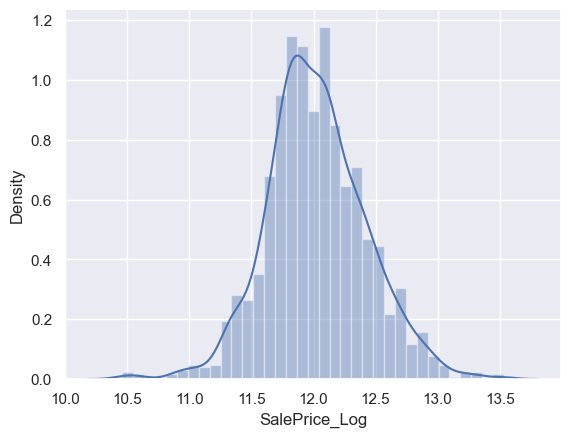

In [14]:
df_train['SalePrice_Log'] = np.log(df_train['SalePrice'])

sns.distplot(df_train['SalePrice_Log']);
# skewness and kurtosis
print('Skewness: %f' % df_train['SalePrice_Log'].skew())
print('Kurtosis: %f' % df_train['SalePrice_Log'].kurt())
# dropping old column
df_train.drop('SalePrice', axis=1, inplace=True)

### Numerical and Categorical Features

In [15]:
numerical_feats = df_train.dtypes[df_train.dtypes != 'object'].index
print('Number of Numerical Features: ', len(numerical_feats))

categorical_feats = df_train.dtypes[df_train.dtypes == 'object'].index
print('Number of Categorical Features: ', len(categorical_feats))

Number of Numerical Features:  38
Number of Categorical Features:  43


In [16]:
print(df_train[numerical_feats].columns)
print('-'*100)
print(df_train[categorical_feats].columns)

Index(['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual',
       'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd',
       'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF',
       'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea',
       'MiscVal', 'MoSold', 'YrSold', 'SalePrice_Log'],
      dtype='object')
----------------------------------------------------------------------------------------------------
Index(['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities',
       'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2',
       'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st',
       'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Founda

In [17]:
df_train[numerical_feats].head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice_Log
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,12.247694
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,12.109011
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,12.317167
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,11.849398
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,12.429216


In [18]:
df_train[categorical_feats].head()

,MSZoning,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,...,GarageType,GarageFinish,GarageQual,GarageCond,PavedDrive,PoolQC,Fence,MiscFeature,SaleType,SaleCondition
0,RL,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
1,RL,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
2,RL,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal
3,RL,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,...,Detchd,Unf,TA,TA,Y,NaN,NaN,NaN,WD,Abnorml
4,RL,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,...,Attchd,RFn,TA,TA,Y,NaN,NaN,NaN,WD,Normal


### List of features with missing values

In [19]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
MasVnrType,872,0.597260
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479


**Filling missing values**
For a few columns there is lots of NaN entries.
However, reading the data description we find this is not missing data: <br>
For PoolQC, NaN is not missing data but means no pool, likewise for Fence, FireplaceQu etc.

In [20]:
# columns where NaN values have meaning e.g. no pool etc.
cols_fillna = ['PoolQC','MiscFeature','Alley','Fence','MasVnrType','FireplaceQu',
               'GarageQual','GarageCond','GarageFinish','GarageType', 'Electrical',
               'KitchenQual', 'SaleType', 'Functional', 'Exterior2nd', 'Exterior1st',
               'BsmtExposure','BsmtCond','BsmtQual','BsmtFinType1','BsmtFinType2',
               'MSZoning', 'Utilities']

# replace 'NaN' with 'None' in these columns
for col in cols_fillna:
    df_train[col].fillna('None',inplace=True)
    df_test[col].fillna('None',inplace=True)

In [21]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
MasVnrArea,8,0.005479
Id,0,0.000000
KitchenAbvGr,0,0.000000


In [22]:
mean_values = df_train[['LotFrontage', 'GarageYrBlt', 'MasVnrArea']].mean()

# Fill missing values in the specified columns with their mean values
df_train['LotFrontage'].fillna(mean_values['LotFrontage'], inplace=True)
df_train['GarageYrBlt'].fillna(mean_values['GarageYrBlt'], inplace=True)
df_train['MasVnrArea'].fillna(mean_values['MasVnrArea'], inplace=True)

In [23]:
total = df_train.isnull().sum().sort_values(ascending=False)
percent = (df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(5)

,Total,Percent
Id,0,0.0
CentralAir,0,0.0
GarageYrBlt,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0


In [24]:
mean_values = df_test[['BsmtFullBath', 'BsmtHalfBath', 'GarageCars', 'TotalBsmtSF', 
                       'BsmtUnfSF', 'BsmtFinSF2', 'GarageArea', 'BsmtFinSF1', 'LotFrontage', 
                       'GarageYrBlt', 'MasVnrArea']].mean()

# Fill missing values in the specified columns with their mean values
df_test['BsmtFullBath'].fillna(mean_values['BsmtFullBath'], inplace=True)
df_test['BsmtHalfBath'].fillna(mean_values['BsmtHalfBath'], inplace=True)
df_test['GarageCars'].fillna(mean_values['GarageCars'], inplace=True)
df_test['TotalBsmtSF'].fillna(mean_values['TotalBsmtSF'], inplace=True)
df_test['BsmtUnfSF'].fillna(mean_values['BsmtUnfSF'], inplace=True)
df_test['BsmtFinSF2'].fillna(mean_values['BsmtFinSF2'], inplace=True)
df_test['GarageArea'].fillna(mean_values['GarageArea'], inplace=True)
df_test['BsmtFinSF1'].fillna(mean_values['BsmtFinSF1'], inplace=True)
df_test['LotFrontage'].fillna(mean_values['LotFrontage'], inplace=True)
df_test['GarageYrBlt'].fillna(mean_values['GarageYrBlt'], inplace=True)
df_test['MasVnrArea'].fillna(mean_values['MasVnrArea'], inplace=True)

In [25]:
total = df_test.isnull().sum().sort_values(ascending=False)
percent = (df_test.isnull().sum()/df_test.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(10)

,Total,Percent
Id,0,0.0
MSSubClass,0,0.0
GarageType,0,0.0
FireplaceQu,0,0.0
Fireplaces,0,0.0
Functional,0,0.0
TotRmsAbvGrd,0,0.0
KitchenQual,0,0.0
KitchenAbvGr,0,0.0
BedroomAbvGr,0,0.0


**Missing values in train data?**

In [26]:
df_train.isnull().sum().sum()

0

**Missing values in test data?**

In [27]:
df_test.isnull().sum().sum()

0

### Log Transform

Like the target variable, also some of the feature values are not normally distributed and it is therefore better to use log values in df_train and df_test. Checking for skewness and kurtosis.

In [28]:
for col in numerical_feats:
    print("{:15}".format(col),
          'Skewness: {:05.2f}'.format(df_train[col].skew()),
          '   ',
          'Kurtosis: {:06.2f}'.format(df_train[col].kurt())
          )

Id              Skewness: 00.00     Kurtosis: -01.20
MSSubClass      Skewness: 01.41     Kurtosis: 001.58
LotFrontage     Skewness: 02.38     Kurtosis: 021.85
LotArea         Skewness: 12.21     Kurtosis: 203.24
OverallQual     Skewness: 00.22     Kurtosis: 000.10
OverallCond     Skewness: 00.69     Kurtosis: 001.11
YearBuilt       Skewness: -0.61     Kurtosis: -00.44
YearRemodAdd    Skewness: -0.50     Kurtosis: -01.27
MasVnrArea      Skewness: 02.68     Kurtosis: 010.15
BsmtFinSF1      Skewness: 01.69     Kurtosis: 011.12
BsmtFinSF2      Skewness: 04.26     Kurtosis: 020.11
BsmtUnfSF       Skewness: 00.92     Kurtosis: 000.47
TotalBsmtSF     Skewness: 01.52     Kurtosis: 013.25
1stFlrSF        Skewness: 01.38     Kurtosis: 005.75
2ndFlrSF        Skewness: 00.81     Kurtosis: -00.55
LowQualFinSF    Skewness: 09.01     Kurtosis: 083.23
GrLivArea       Skewness: 01.37     Kurtosis: 004.90
BsmtFullBath    Skewness: 00.60     Kurtosis: -00.84
BsmtHalfBath    Skewness: 04.10     Kurtosis: 

C:\Users\cW\AppData\Local\Temp\ipykernel_17828\2373253150.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['GrLivArea']);


Skewness: 1.366560
Kurtosis: 4.895121


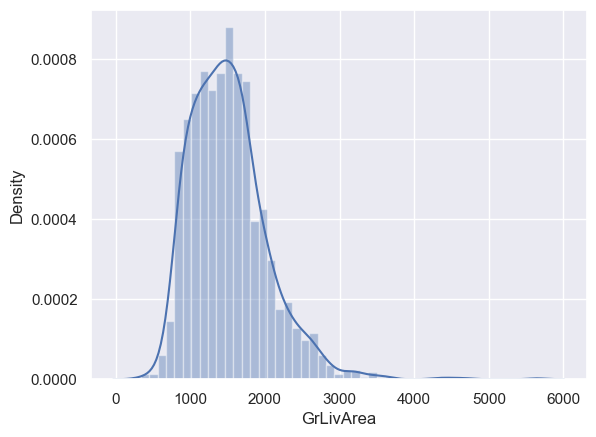

In [29]:
sns.distplot(df_train['GrLivArea']);

# skewness and kurtosis
print('Skewness: %f' % df_train['GrLivArea'].skew())
print('Kurtosis: %f' % df_train['GrLivArea'].kurt())

C:\Users\cW\AppData\Local\Temp\ipykernel_17828\2509222364.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['LotArea']);


Skewness: 12.207688
Kurtosis: 203.243271


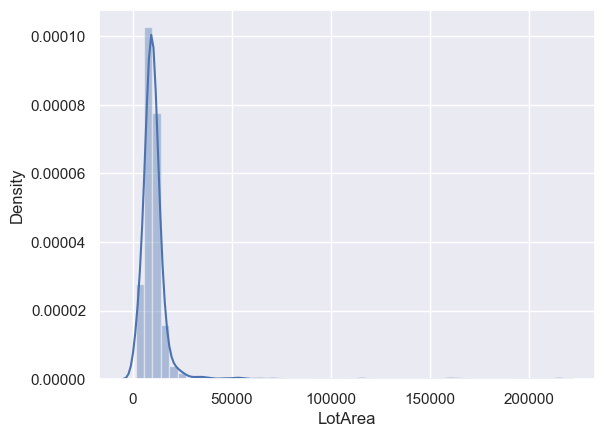

In [30]:
sns.distplot(df_train['LotArea']);
# skewness and kurtosis
print('Skewness: %f' % df_train['LotArea'].skew())
print('Kurtosis: %f' % df_train['LotArea'].kurt())

In [31]:
for df in [df_train, df_test]:
    df['GrLivArea_log'] = np.log(df['GrLivArea'])
    df.drop('GrLivArea', inplace=True, axis=1)
    df['LotArea_Log'] = np.log(df['LotArea'])
    df.drop('LotArea', inplace=True, axis=1)

In [32]:
numerical_feats = df_train.dtypes[df_train.dtypes != 'object'].index

C:\Users\cW\AppData\Local\Temp\ipykernel_17828\3555431940.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['GrLivArea_log']);


Skewness: -0.006995
Kurtosis: 0.282603


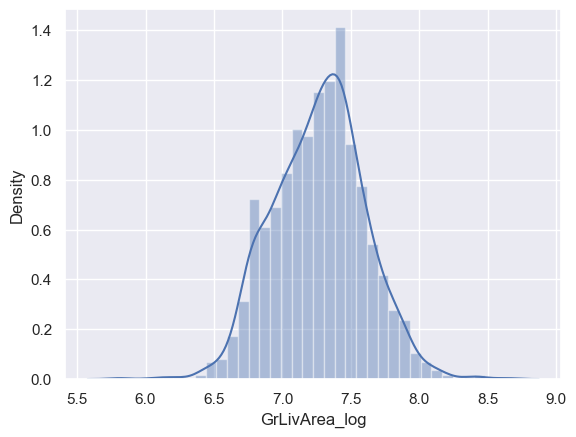

In [33]:
sns.distplot(df_train['GrLivArea_log']);

# skewness and kurtosis:
print('Skewness: %f' % df_train['GrLivArea_log'].skew())
print('Kurtosis: %f' % df_train['GrLivArea_log'].kurt())

C:\Users\cW\AppData\Local\Temp\ipykernel_17828\3556703612.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df_train['LotArea_Log']);


Skewness: -0.137994
Kurtosis: 4.713358


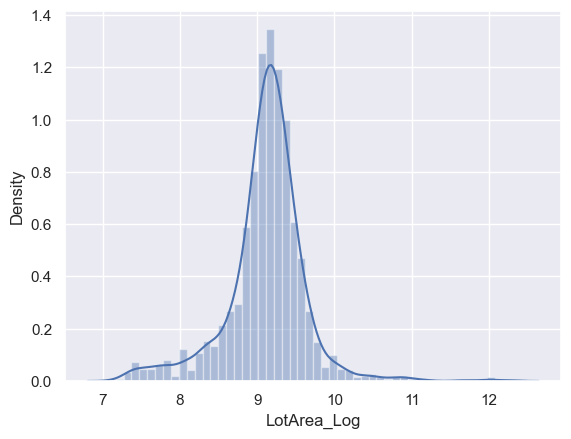

In [34]:
sns.distplot(df_train['LotArea_Log']);

# skewness and kurtosis
print('Skewness: %f' % df_train['LotArea_Log'].skew())
print('Kurtosis: %f' % df_train['LotArea_Log'].kurt())

## 1.2 Relation of Features to Target (SalePrice_log)

### Plots of relation to target for all numerical features

In [35]:
df_train.columns

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'Street', 'Alley',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr',
       'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd', 'Functional',
       'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt',
       'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual', 'GarageCond',
       'PavedDrive', 'WoodDeckSF', 'OpenPo

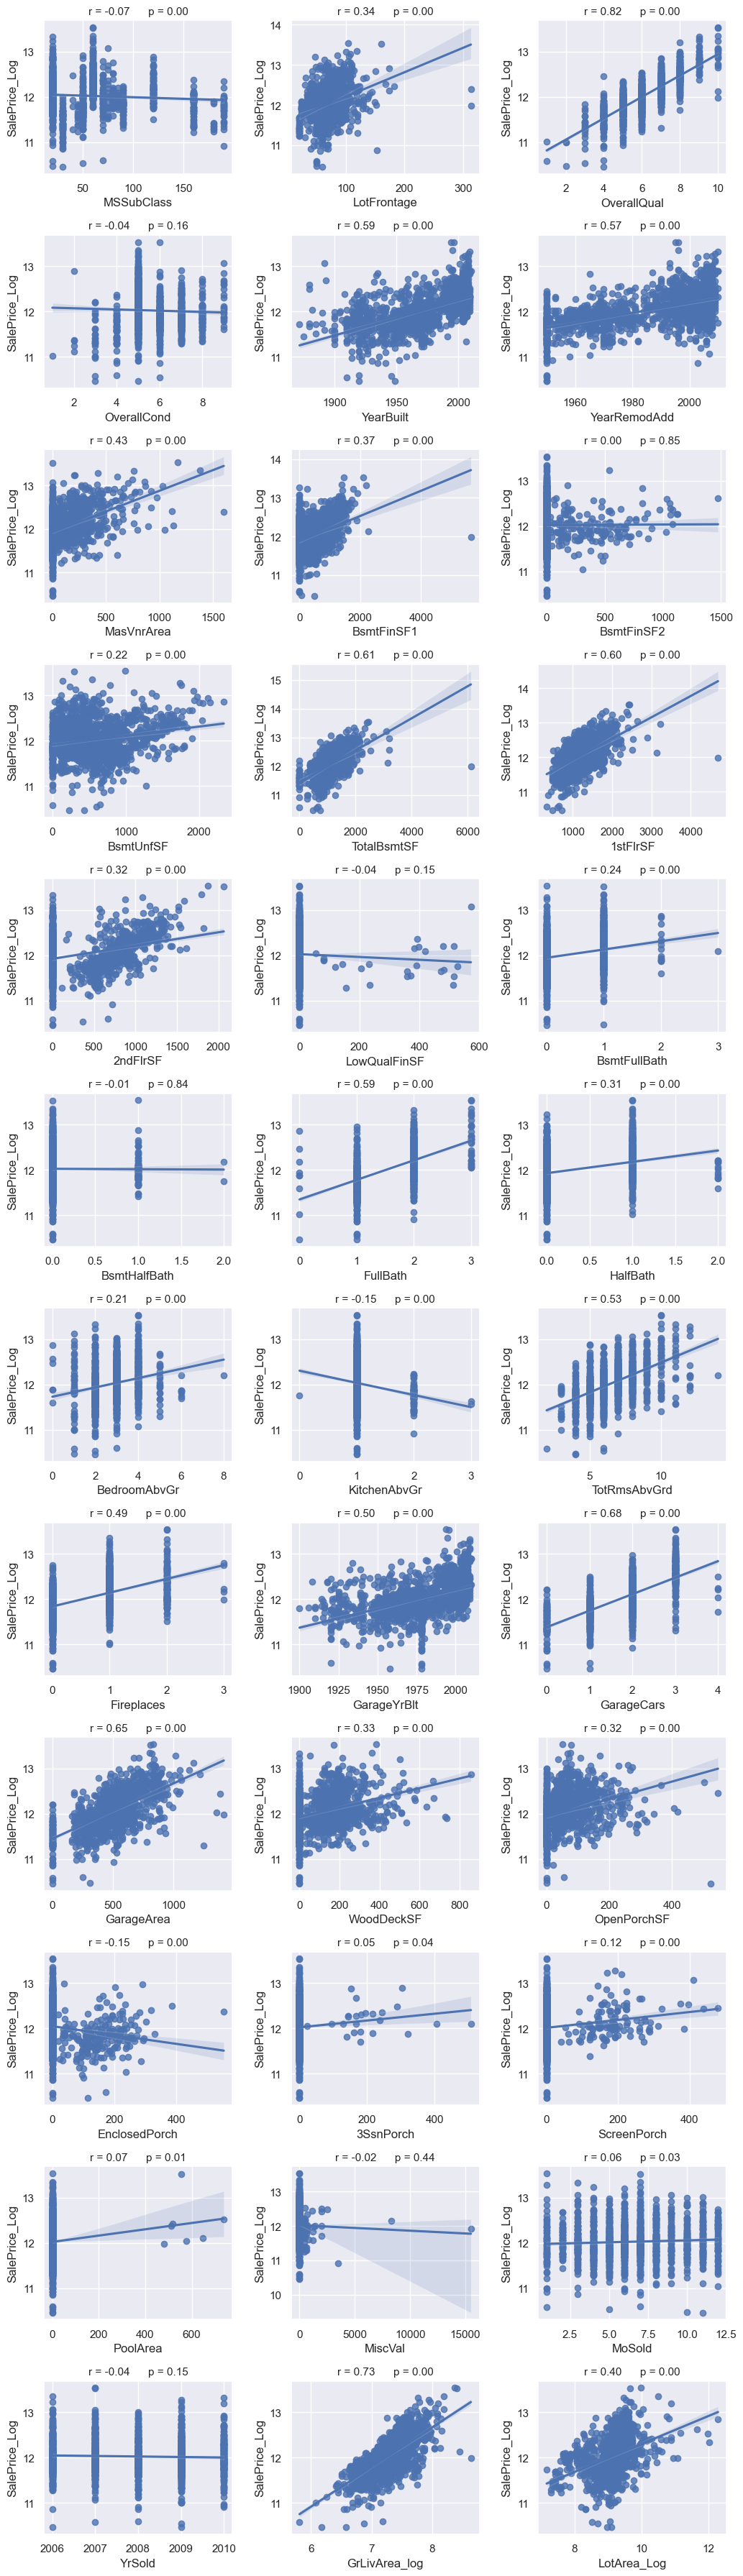

In [36]:
# nr_rows = 12
# nr_cols = 3

# fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5,nr_rows*3))

# li_num_feats = list(numerical_feats)
# li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
# li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]


# for r in range(0,nr_rows):
#     for c in range(0,nr_cols):  
#         i = r*nr_cols+c
#         if i < len(li_plot_num_feats):
#             sns.regplot(df_train[li_plot_num_feats[i]], df_train[target], ax = axs[r][c])
#             stp = stats.pearsonr(df_train[li_plot_num_feats[i]], df_train[target])
#             #axs[r][c].text(0.4,0.9,"title",fontsize=7)
#             str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
#             axs[r][c].set_title(str_title,fontsize=11)
            
# plt.tight_layout()    
# plt.show()


nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

li_num_feats = list(numerical_feats)
li_not_plot = ['Id', 'SalePrice', 'SalePrice_Log']
li_plot_num_feats = [c for c in list(numerical_feats) if c not in li_not_plot]

for r in range(0, nr_rows):
    for c in range(0, nr_cols):  
        i = r * nr_cols + c
        if i < len(li_plot_num_feats):
            x_col = df_train[li_plot_num_feats[i]]
            y_col = df_train[target]
            sns.regplot(x=x_col, y=y_col, data=df_train, ax=axs[r][c])
            stp = stats.pearsonr(x_col, y_col)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)

plt.tight_layout()    
plt.show()

**Conclusion from EDA on numerical columns:**

We see that for some features like 'OverallQual' there is a strong linear correlation (0.79) to the target. <br>
For other features like 'MSSubClass' the correlation is vert weak. <br>
For this kernel I decided to use only those features for prediction that have a correlation larget than a threshold value to SalePrice. <br>
This threshold value can be choosen in the global settings: min_val_corr <br>

With the default threshold for min_val_corr = 0.4, these features are dropped in Part 2, Data Wrangling: <br>
'Id', 'MSSubClass', 'LotArea', 'OverallCond', 'BsmtFinSF2', 'BsmtUnfSF',  'LowQualFinSF',  'BsmtFullBath', 'BsmtHalfBath', 'HalfBath',   
'BedroomAbvGr', 'KitchenAbvGr', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold'

We also see that the entries for some of the numerical columns are in fact categorical values. <br>
For example, the numbers for 'OverallQual' and 'MSSubClass' represent a certain group for that feature (see data description text)

**Outliers**

In [37]:
df_train = df_train.drop(
    df_train[(df_train['OverallQual']==10) & (df_train['SalePrice_Log'] < 12.3)].index
)

In [38]:
df_train = df_train.drop(
    df_train[(df_train['GrLivArea_log']>8.3) & (df_train['SalePrice_Log']<12.5)].index
)

**Find columns with strong correlation to target**

Only those with r > min_val_corr are used in the ML Regressors in Part 3. The value for min_val_corr can be chosen in global settings

In [39]:
numberss = df_train.select_dtypes(include=['number'])
corr = numberss.corr()
corr_abs = corr.abs()

nr_num_cols = len(numerical_feats)
ser_corr = corr_abs.nlargest(nr_num_cols, target)[target]

min_val_corr = 0.5  # Define your minimum correlation value here

cols_abv_corr_limit = list(ser_corr[ser_corr.values > min_val_corr].index)
cols_bel_corr_limit = list(ser_corr[ser_corr.values <= min_val_corr].index)

print("Columns with correlation above", min_val_corr, ":", cols_abv_corr_limit)
print("Columns with correlation below or equal to", min_val_corr, ":", cols_bel_corr_limit)

Columns with correlation above 0.5 : ['SalePrice_Log', 'OverallQual', 'GrLivArea_log', 'GarageCars', 'GarageArea', 'TotalBsmtSF', '1stFlrSF', 'FullBath', 'YearBuilt', 'YearRemodAdd', 'TotRmsAbvGrd', 'GarageYrBlt']
Columns with correlation below or equal to 0.5 : ['Fireplaces', 'MasVnrArea', 'LotArea_Log', 'BsmtFinSF1', 'LotFrontage', 'WoodDeckSF', 'OpenPorchSF', '2ndFlrSF', 'HalfBath', 'BsmtFullBath', 'BsmtUnfSF', 'BedroomAbvGr', 'EnclosedPorch', 'KitchenAbvGr', 'ScreenPorch', 'PoolArea', 'MSSubClass', 'MoSold', '3SsnPorch', 'LowQualFinSF', 'YrSold', 'OverallCond', 'MiscVal', 'Id', 'BsmtHalfBath', 'BsmtFinSF2']


### List of Numerical features and their correlation coefficient to target

In [40]:
print(ser_corr)
print("*"*30)
print('List of numerical features with r above min_val_corr: ')
print(cols_abv_corr_limit)
print('*'*30)
print('List of numerical features with r below min_val_corr: ')
print(cols_bel_corr_limit)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_log    0.737427
GarageCars       0.681033
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Fireplaces       0.491998
MasVnrArea       0.433353
LotArea_Log      0.402814
BsmtFinSF1       0.392283
LotFrontage      0.352432
WoodDeckSF       0.334250
OpenPorchSF      0.325215
2ndFlrSF         0.319953
HalfBath         0.314186
BsmtFullBath     0.237099
BsmtUnfSF        0.221892
BedroomAbvGr     0.209036
EnclosedPorch    0.149029
KitchenAbvGr     0.147534
ScreenPorch      0.121245
PoolArea         0.074338
MSSubClass       0.073969
MoSold           0.057064
3SsnPorch        0.054914
LowQualFinSF     0.037951
YrSold           0.037151
OverallCond      0.036821
MiscVal          0.020012
Id               0.017774
BsmtHalfBath     0.005124
BsmtFinSF2       0.004863
Name: SalePr

### List of categorical features and their unique values

In [41]:
for catg in list(categorical_feats):
    print(df_train[catg].value_counts())
    print('#'*50)

MSZoning
RL         1149
RM          218
FV           65
RH           16
C (all)      10
Name: count, dtype: int64
##################################################
Street
Pave    1452
Grvl       6
Name: count, dtype: int64
##################################################
Alley
None    1367
Grvl      50
Pave      41
Name: count, dtype: int64
##################################################
LotShape
Reg    925
IR1    483
IR2     41
IR3      9
Name: count, dtype: int64
##################################################
LandContour
Lvl    1311
Bnk      61
HLS      50
Low      36
Name: count, dtype: int64
##################################################
Utilities
AllPub    1457
NoSeWa       1
Name: count, dtype: int64
##################################################
LotConfig
Inside     1051
Corner      262
CulDSac      94
FR2          47
FR3           4
Name: count, dtype: int64
##################################################
LandSlope
Gtl    1380
Mod      65
Sev      13
Name:

### Relation to SalePrice for all Categorical features

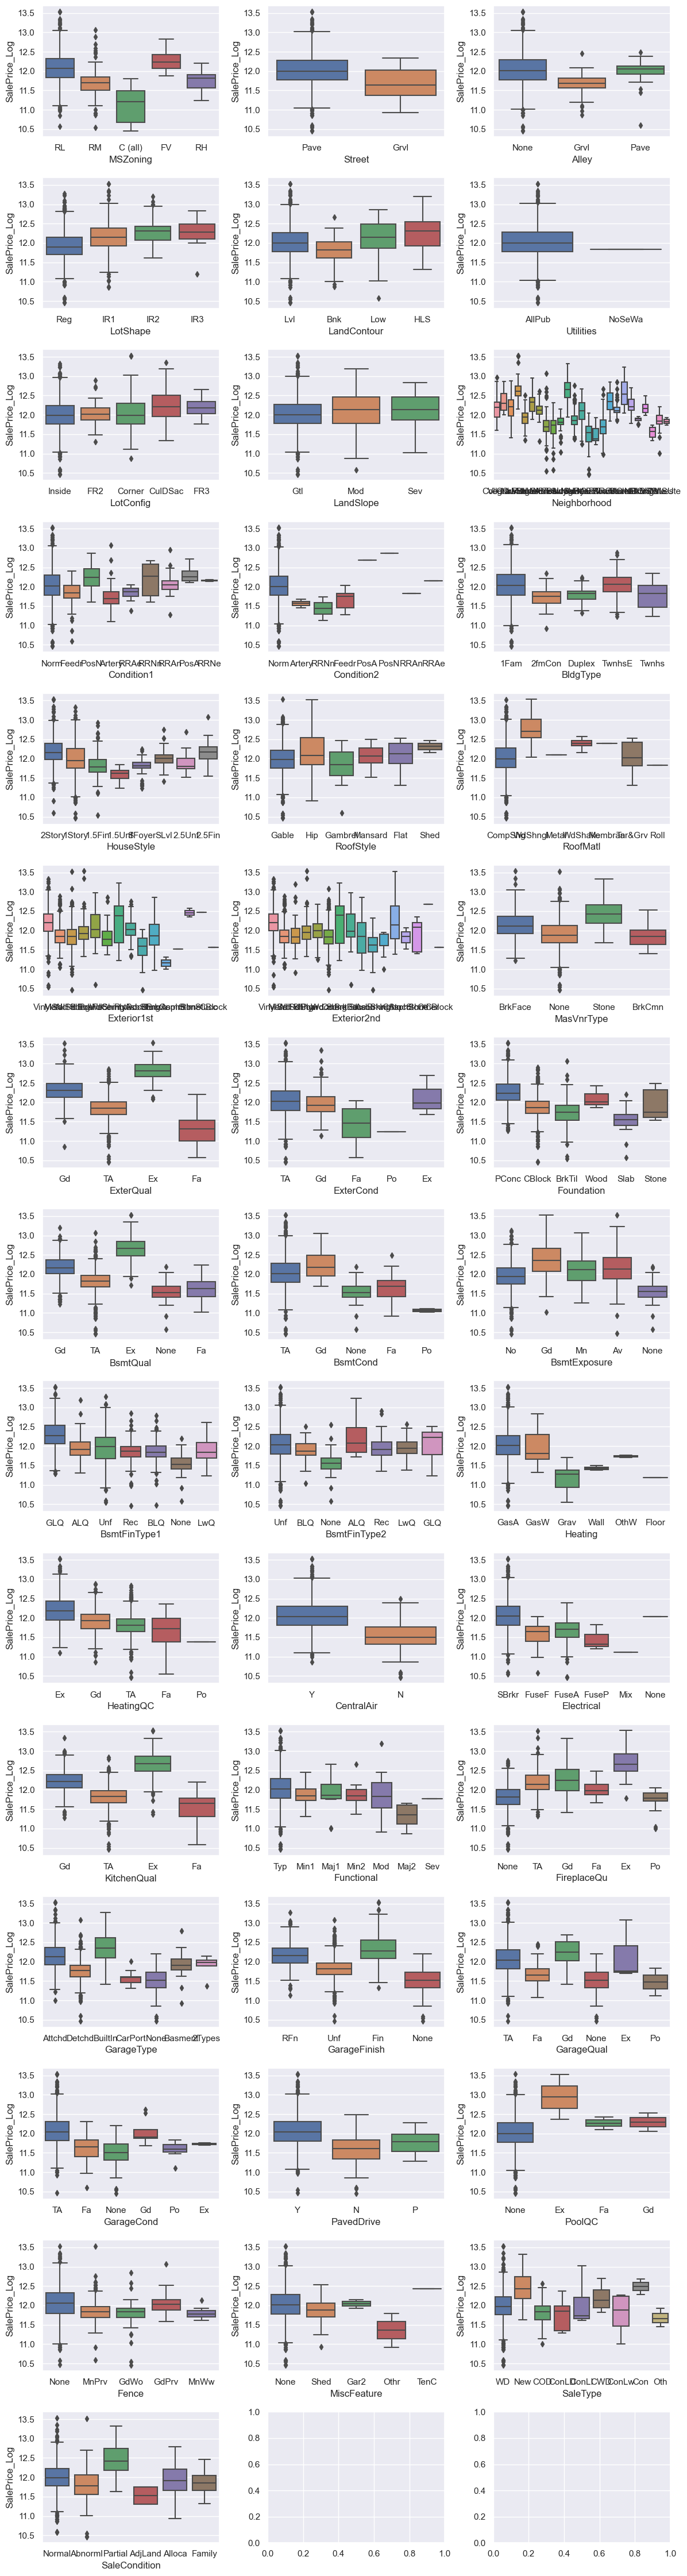

In [42]:
li_cat_feats = list(categorical_feats)
nr_rows = 15
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*4, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):
        i = r*nr_cols+c
        if i < len(li_cat_feats):
            sns.boxplot(x=li_cat_feats[i], y=target, data=df_train, ax = axs[r][c])

plt.tight_layout()
plt.show()

**Conclusion from EDA on categorical columns:**

For many of the categorical there is no strong relation to the target.  
However, for some fetaures it is easy to find a strong relation.  
From the figures above these are : 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType'
Also for the categorical features, I use only those that show a strong relation to SalePrice. 
So the other columns are dropped when creating the ML dataframes in Part 2 :  
 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl',
'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 
'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 'SaleCondition' 

In [43]:
catg_strong_corr = [ 'MSZoning', 'Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 
                     'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']

catg_weak_corr = ['Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 
                  'LandSlope', 'Condition1',  'BldgType', 'HouseStyle', 'RoofStyle', 
                  'RoofMatl', 'Exterior1st', 'Exterior2nd', 'ExterCond', 'Foundation', 
                  'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 
                  'HeatingQC', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 
                  'GarageQual', 'GarageCond', 'PavedDrive', 'PoolQC', 'Fence', 'MiscFeature', 
                  'SaleCondition' ]
      

### Correlation matrix 1

**Features with largest correlation to SalePrice_Log** <br>
all numerical features with correlation coefficient above threshold

In [44]:
nr_feats = len(cols_abv_corr_limit)

In [45]:
def plot_corr_matrix(df, nr_c, targ):
    corr = df.corr()
    corr_abs = corr.abs()  # Compute absolute correlations
    
    cols = corr_abs.nlargest(nr_c, targ)[targ].index
    cm = np.corrcoef(df[cols].values.T)
    
    sns.set(font_scale=1.25)
    plt.figure(figsize=(nr_c, nr_c))
    hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
    plt.show()

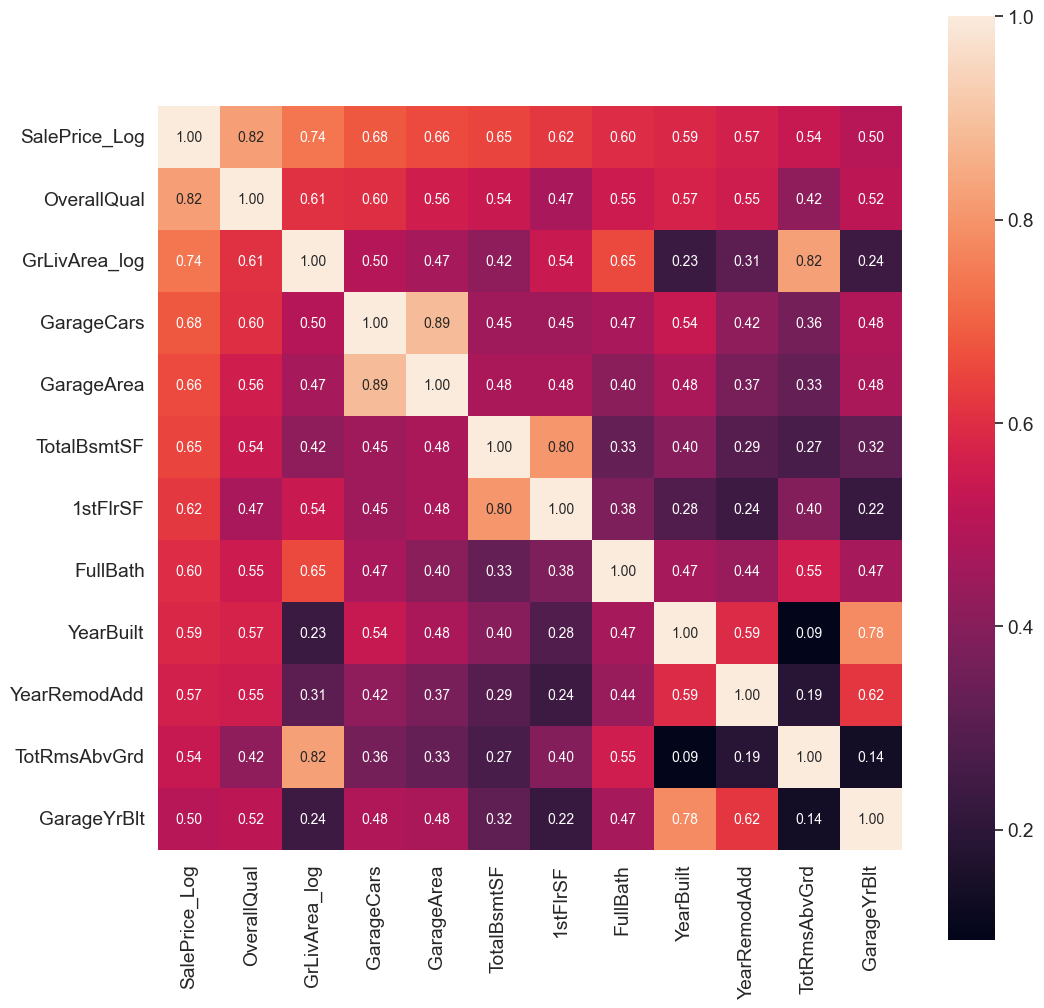

In [46]:
numberss = df_train.select_dtypes(include=['number'])
nr_feats = len(cols_abv_corr_limit)  # Set the number of features you want to display in the correlation matrix
plot_corr_matrix(numberss, nr_feats, target)

**Of those features with the largest correlation to SalePrice, some also are correlated to each other.**

**To avoid failures of the ML regression models due to multicollinearity, these are dropped in part 2**

**This is optional and controlled by the switch drop_similar (global settings)**

# Part 2: Data Wrangling

**Drop all columns with only small correlation to SalePrice** <br>
**Transform Categorical to numerical** <br>
**Handling columns with missing data** <br>
**Log Values**<br>
**Drop all columns with strong correlation to similar features** <br>

Numerical columns: drop similar and low correlation <br>
Categorical columns: transform to numerical

### Dropping all columns with weak correlation to SalePrice

In [47]:
id_test = df_test['Id']

to_drop_num = cols_bel_corr_limit
to_drop_catg = catg_weak_corr

cols_to_drop = ['Id'] + to_drop_num + to_drop_catg

for df in [df_train, df_test]:
    df.drop(cols_to_drop, inplace=True, axis=1)

### Convert Categorical columns to Numerical

For those categorical features where the EDA with boxplots seem to show a strong dependence of the SalePrice on the category, we transform the columns to numerical. To inverstigate the relation of the categories to SalePrice in more detail, we make violinplots for these features. Also, we look at the mean of SalePrice as function of category.

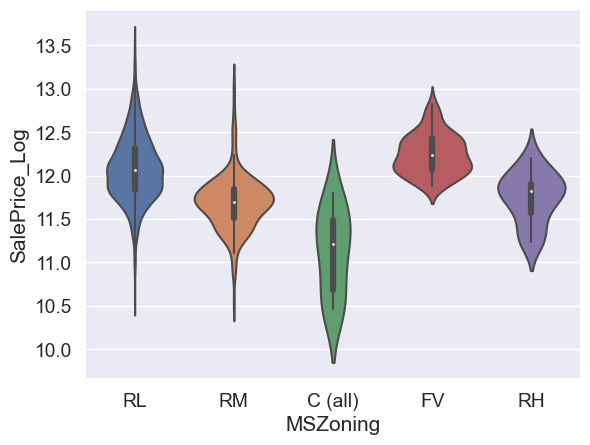

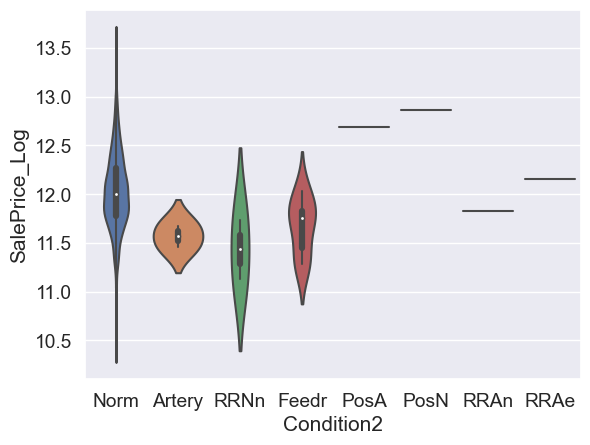

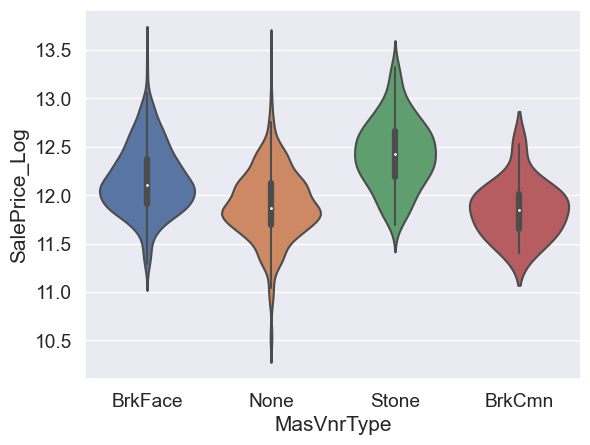

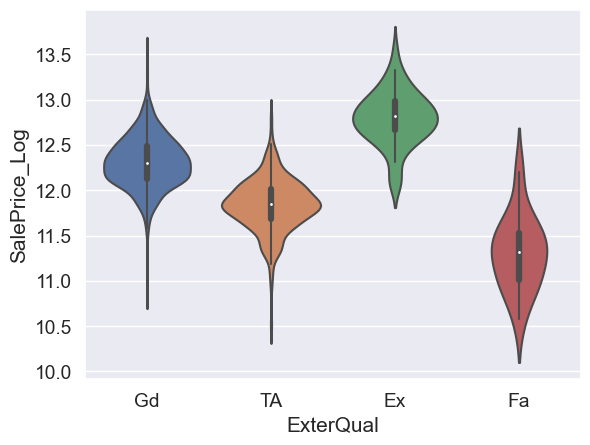

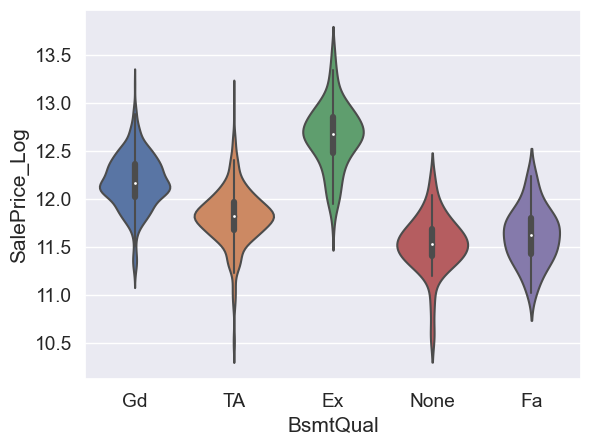

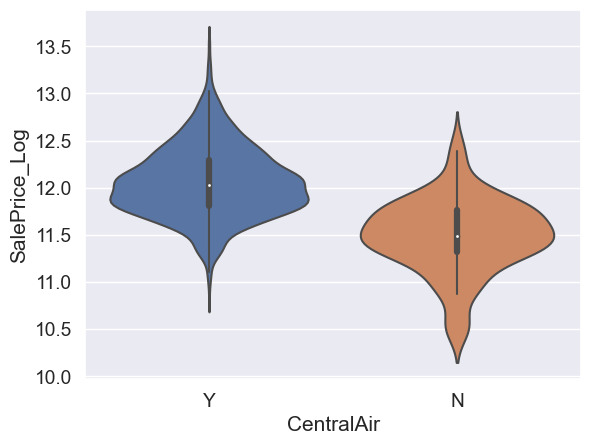

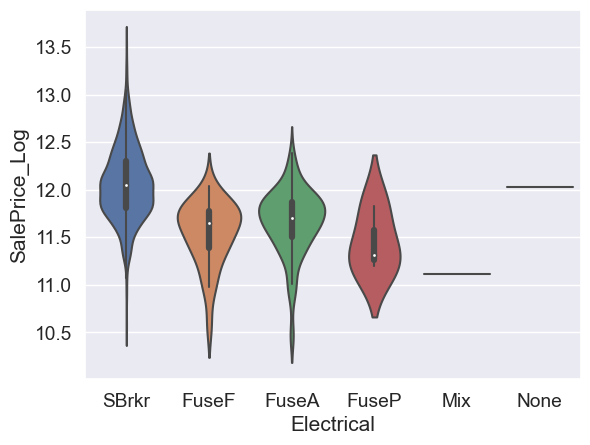

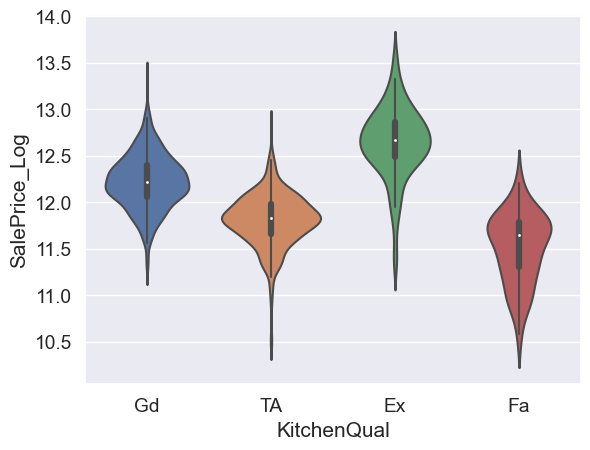

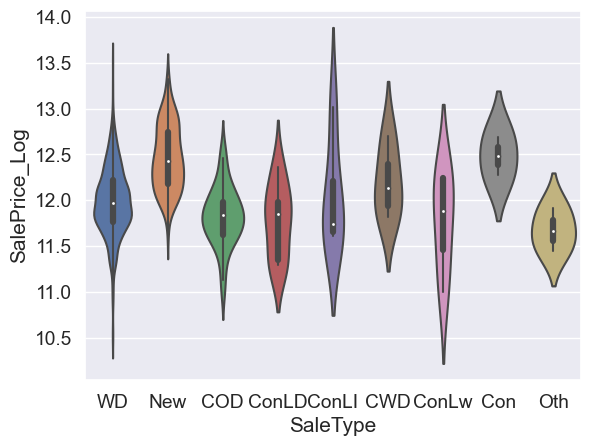

In [48]:
catg_list = catg_strong_corr.copy()
catg_list.remove('Neighborhood')

for catg in catg_list:
    sns.violinplot(x=catg, y=target, data=df_train)
    plt.show()

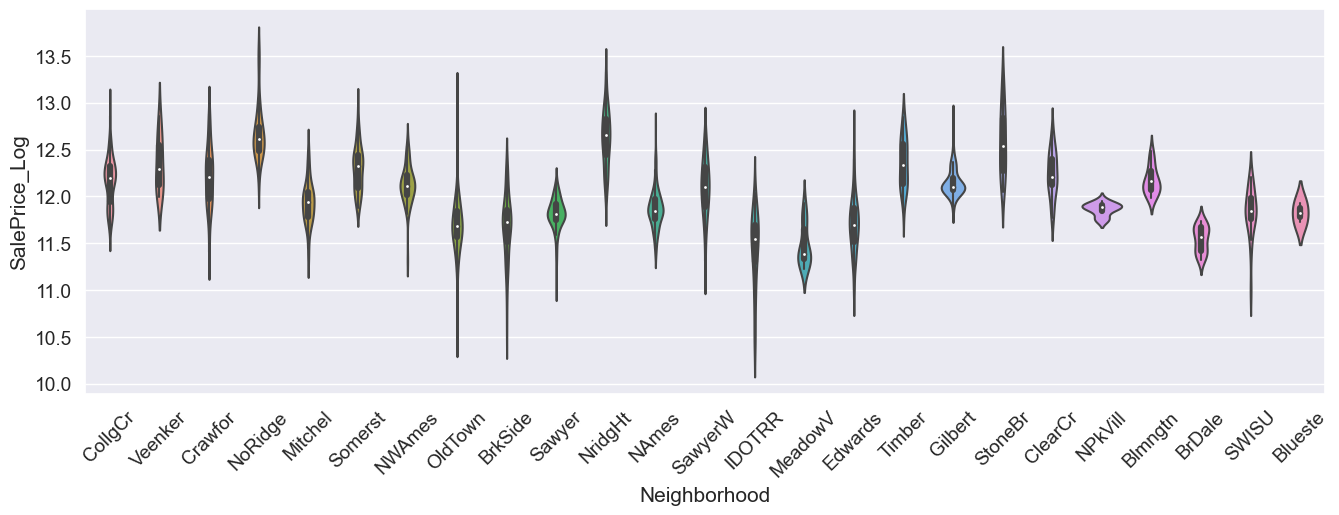

In [49]:
fig, ax = plt.subplots()
fig.set_size_inches(16, 5)
sns.violinplot(x='Neighborhood', y=target, data=df_train, ax=ax)
plt.xticks(rotation=45)
plt.show()

In [50]:
for catg in catg_list:
    g = df_train.groupby(catg)[target].mean()
    print(g)

MSZoning
C (all)    11.118259
FV         12.246616
RH         11.749840
RL         12.085939
RM         11.692893
Name: SalePrice_Log, dtype: float64
Condition2
Artery    11.570036
Feedr     11.670631
Norm      12.025925
PosA      12.691580
PosN      12.860999
RRAe      12.154779
RRAn      11.827043
RRNn      11.435329
Name: SalePrice_Log, dtype: float64
MasVnrType
BrkCmn     11.853239
BrkFace    12.163630
None       11.896884
Stone      12.431016
Name: SalePrice_Log, dtype: float64
ExterQual
Ex    12.792412
Fa    11.304541
Gd    12.311282
TA    11.837985
Name: SalePrice_Log, dtype: float64
BsmtQual
Ex      12.650235
Fa      11.617600
Gd      12.179882
None    11.529680
TA      11.810855
Name: SalePrice_Log, dtype: float64
CentralAir
N    11.491858
Y    12.061099
Name: SalePrice_Log, dtype: float64
Electrical
FuseA    11.660315
FuseF    11.539624
FuseP    11.446808
Mix      11.112448
None     12.028739
SBrkr    12.061474
Name: SalePrice_Log, dtype: float64
KitchenQual
Ex    12.645425
F

In [51]:
# 'MSZoning'

msz_catg2 = ['RM', 'RH']
msz_catg3 = ['RL', 'FV']

# neighborhood
nbhd_catg2 = ['Blmngtn', 'ClearCr', 'CollgCr', 'Crawfor', 'Gilbert', 'NWAmes', 'Somerst', 'Timber', 'Veenker']
nbhd_catg3 = ['NoRidge', 'NridgHt', 'StoneBr']

# condition2
cond2_catg2 = ['Norm', 'RRAe']
cond2_catg3 = ['PosA', 'PosN']

# styletype
SlTy_catg1 = ['Oth']
SlTy_catg3 = ['CWD']
SlTy_catg4 = ['New', 'Con']

In [52]:
for df in [df_train, df_test]:
    
    df['MSZ_num'] = 1  
    df.loc[(df['MSZoning'].isin(msz_catg2) ), 'MSZ_num'] = 2    
    df.loc[(df['MSZoning'].isin(msz_catg3) ), 'MSZ_num'] = 3        
    
    df['NbHd_num'] = 1       
    df.loc[(df['Neighborhood'].isin(nbhd_catg2) ), 'NbHd_num'] = 2    
    df.loc[(df['Neighborhood'].isin(nbhd_catg3) ), 'NbHd_num'] = 3    

    df['Cond2_num'] = 1       
    df.loc[(df['Condition2'].isin(cond2_catg2) ), 'Cond2_num'] = 2    
    df.loc[(df['Condition2'].isin(cond2_catg3) ), 'Cond2_num'] = 3    
    
    df['Mas_num'] = 1       
    df.loc[(df['MasVnrType'] == 'Stone' ), 'Mas_num'] = 2 
    
    df['ExtQ_num'] = 1       
    df.loc[(df['ExterQual'] == 'TA' ), 'ExtQ_num'] = 2     
    df.loc[(df['ExterQual'] == 'Gd' ), 'ExtQ_num'] = 3     
    df.loc[(df['ExterQual'] == 'Ex' ), 'ExtQ_num'] = 4     
   
    df['BsQ_num'] = 1          
    df.loc[(df['BsmtQual'] == 'Gd' ), 'BsQ_num'] = 2     
    df.loc[(df['BsmtQual'] == 'Ex' ), 'BsQ_num'] = 3     
 
    df['CA_num'] = 0          
    df.loc[(df['CentralAir'] == 'Y' ), 'CA_num'] = 1    

    df['Elc_num'] = 1       
    df.loc[(df['Electrical'] == 'SBrkr' ), 'Elc_num'] = 2 


    df['KiQ_num'] = 1       
    df.loc[(df['KitchenQual'] == 'TA' ), 'KiQ_num'] = 2     
    df.loc[(df['KitchenQual'] == 'Gd' ), 'KiQ_num'] = 3     
    df.loc[(df['KitchenQual'] == 'Ex' ), 'KiQ_num'] = 4      
    
    df['SlTy_num'] = 2       
    df.loc[(df['SaleType'].isin(SlTy_catg1) ), 'SlTy_num'] = 1  
    df.loc[(df['SaleType'].isin(SlTy_catg3) ), 'SlTy_num'] = 3  
    df.loc[(df['SaleType'].isin(SlTy_catg4) ), 'SlTy_num'] = 4  

### Checking correlation to SalePrice for the new numerical columns

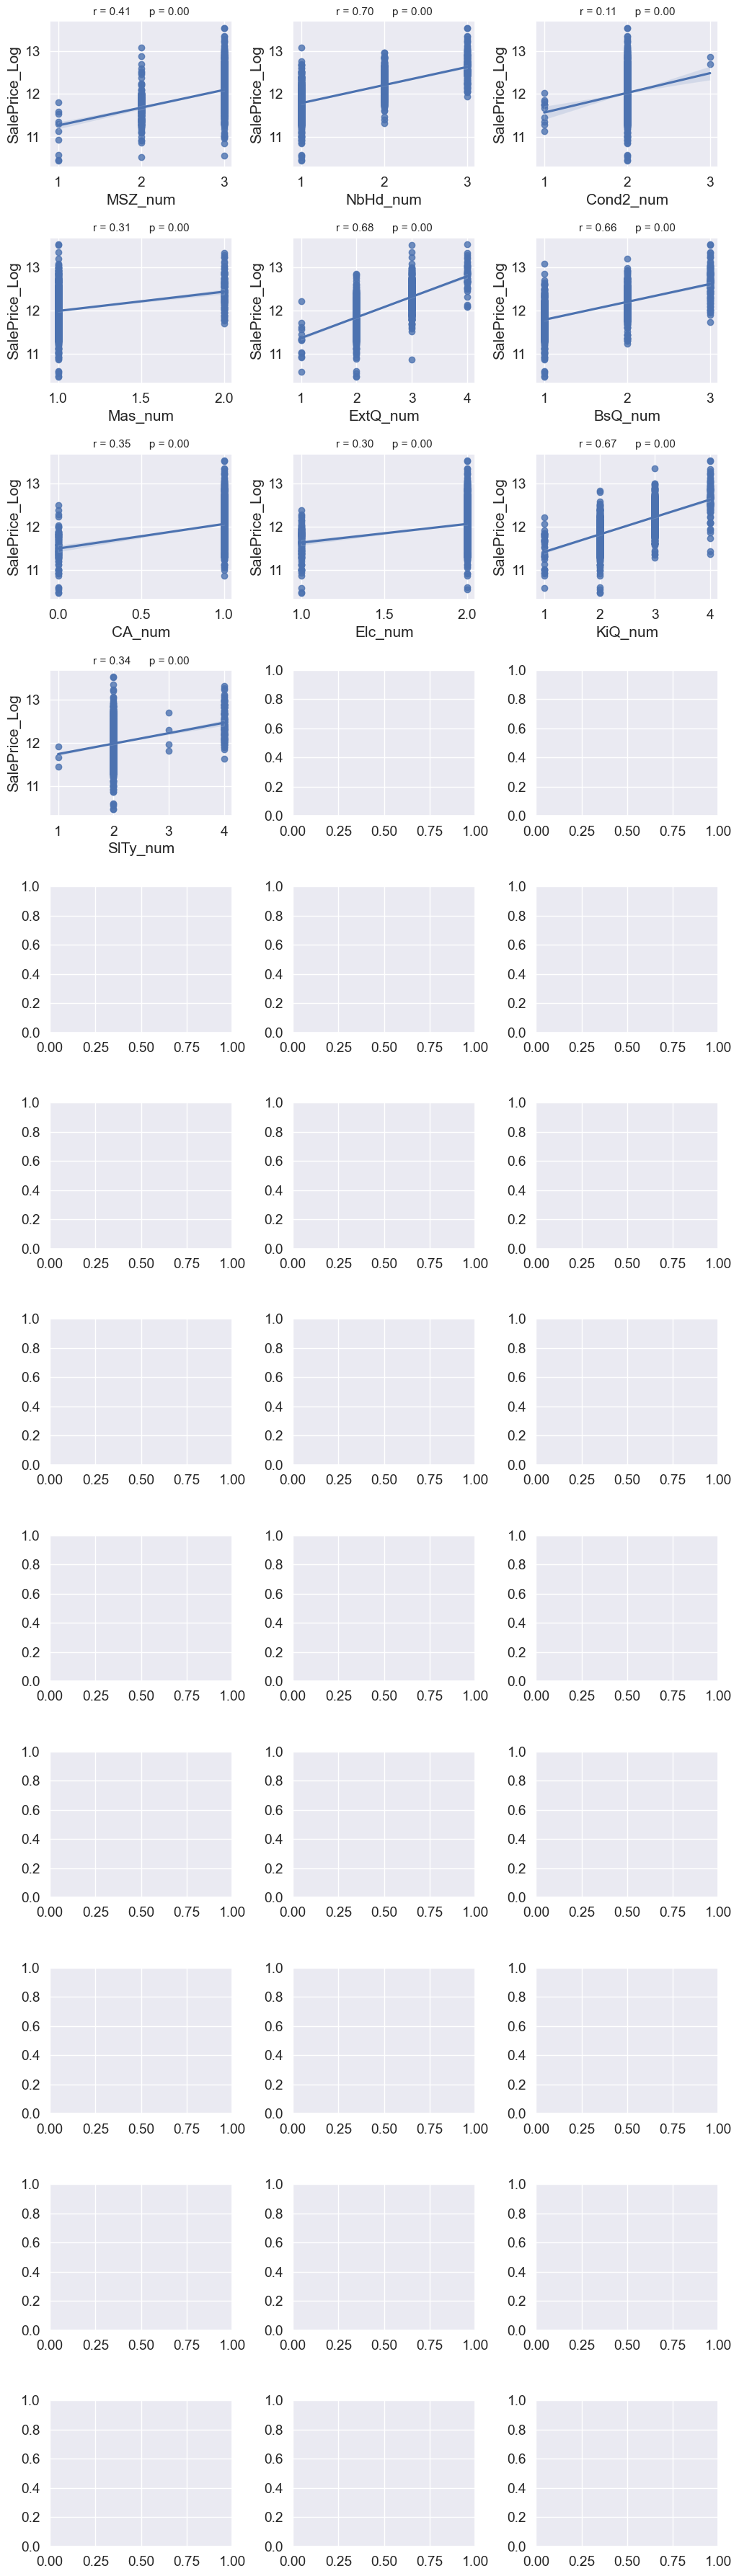

In [53]:
new_col_num = ['MSZ_num', 'NbHd_num', 'Cond2_num', 'Mas_num', 'ExtQ_num', 'BsQ_num', 'CA_num', 'Elc_num', 'KiQ_num', 'SlTy_num']

nr_rows = 12
nr_cols = 3

fig, axs = plt.subplots(nr_rows, nr_cols, figsize=(nr_cols*3.5, nr_rows*3))

for r in range(0, nr_rows):
    for c in range(0, nr_cols):  
        i = r * nr_cols + c
        if i < len(new_col_num):
            x_col = df_train[new_col_num[i]]
            y_col = df_train[target]
            sns.regplot(x=x_col, y=y_col, data=df_train, ax=axs[r][c])
            stp = stats.pearsonr(x_col, y_col)
            str_title = "r = " + "{0:.2f}".format(stp[0]) + "      " "p = " + "{0:.2f}".format(stp[1])
            axs[r][c].set_title(str_title, fontsize=11)

plt.tight_layout()    
plt.show()

There are few columns with quite large correlation to SalePrice (NbHd_num, ExtQ_num, BsQ_num, KiQ_num).

These will probably be useful for optimal performance of the Regressors in part 3. <br>

**Dropping the converted categorical columns and the new numerical columns with weak correlation**

**columns and correlation before dropping**

In [54]:
catg_cols_to_drop = ['Neighborhood', 'Condition2', 'MasVnrType', 'ExterQual', 'BsmtQual','CentralAir', 'Electrical', 'KitchenQual', 'SaleType']
numm = df_train.select_dtypes(include=['number'])
corr1 = numm.corr()
corr_abs_1 = corr1.abs()

nr_all_cols = len(df_train)
ser_corr_1 = corr_abs_1.nlargest(nr_all_cols, target)[target]

print(ser_corr_1)
cols_bel_corr_limit_1 = list(ser_corr_1[ser_corr_1.values <= min_val_corr].index)

for df in [df_train, df_test]:
    df.drop(catg_cols_to_drop, inplace=True, axis=1)
    df.drop(cols_bel_corr_limit_1, inplace=True, axis=1)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
MSZ_num          0.409423
CA_num           0.351598
SlTy_num         0.337469
Mas_num          0.313280
Elc_num          0.304857
Cond2_num        0.107610
Name: SalePrice_Log, dtype: float64


**columns and correlation after dropping**

In [55]:
numm_2 = df_train.select_dtypes(include=['number'])
corr2 = numm_2.corr()
corr_abs_2 = corr2.abs()

nr_all_cols = len(df_train)
ser_corr_2 = corr_abs_2.nlargest(nr_all_cols, target)[target]

print(ser_corr_2)

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Name: SalePrice_Log, dtype: float64


**new dataframes**

In [56]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice_Log,GrLivArea_log,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RL,7,2003,2003,856,856,2,8,2003.0,2,548,12.247694,7.444249,2,3,2,3
1,RL,6,1976,1976,1262,1262,2,6,1976.0,2,460,12.109011,7.140453,2,2,2,2
2,RL,7,2001,2002,920,920,2,6,2001.0,2,608,12.317167,7.487734,2,3,2,3
3,RL,7,1915,1970,756,961,1,7,1998.0,3,642,11.849398,7.448334,2,2,1,3
4,RL,8,2000,2000,1145,1145,2,9,2000.0,3,836,12.429216,7.695303,3,3,2,3


In [57]:
df_train.head()

,MSZoning,OverallQual,YearBuilt,YearRemodAdd,TotalBsmtSF,1stFlrSF,FullBath,TotRmsAbvGrd,GarageYrBlt,GarageCars,GarageArea,SalePrice_Log,GrLivArea_log,NbHd_num,ExtQ_num,BsQ_num,KiQ_num
0,RL,7,2003,2003,856,856,2,8,2003.0,2,548,12.247694,7.444249,2,3,2,3
1,RL,6,1976,1976,1262,1262,2,6,1976.0,2,460,12.109011,7.140453,2,2,2,2
2,RL,7,2001,2002,920,920,2,6,2001.0,2,608,12.317167,7.487734,2,3,2,3
3,RL,7,1915,1970,756,961,1,7,1998.0,3,642,11.849398,7.448334,2,2,1,3
4,RL,8,2000,2000,1145,1145,2,9,2000.0,3,836,12.429216,7.695303,3,3,2,3


**List of all features with strong correlation to SalePrice_Log** <br>
after dropping all columns with weak correlation

In [58]:
numm_3 = df_train.select_dtypes(include=['number'])
corr = numm_3.corr()
corr_abs = corr.abs()

nr_all_cols = len(df_train)
print(corr_abs.nlargest(nr_all_cols, target)[target])

SalePrice_Log    1.000000
OverallQual      0.821404
GrLivArea_log    0.737427
NbHd_num         0.696962
ExtQ_num         0.682225
GarageCars       0.681033
KiQ_num          0.669989
BsQ_num          0.661286
GarageArea       0.656128
TotalBsmtSF      0.647563
1stFlrSF         0.620500
FullBath         0.595899
YearBuilt        0.587043
YearRemodAdd     0.565992
TotRmsAbvGrd     0.537702
GarageYrBlt      0.500842
Name: SalePrice_Log, dtype: float64


### Correlation Matrix 2: All features with strong correlation to SalePrice

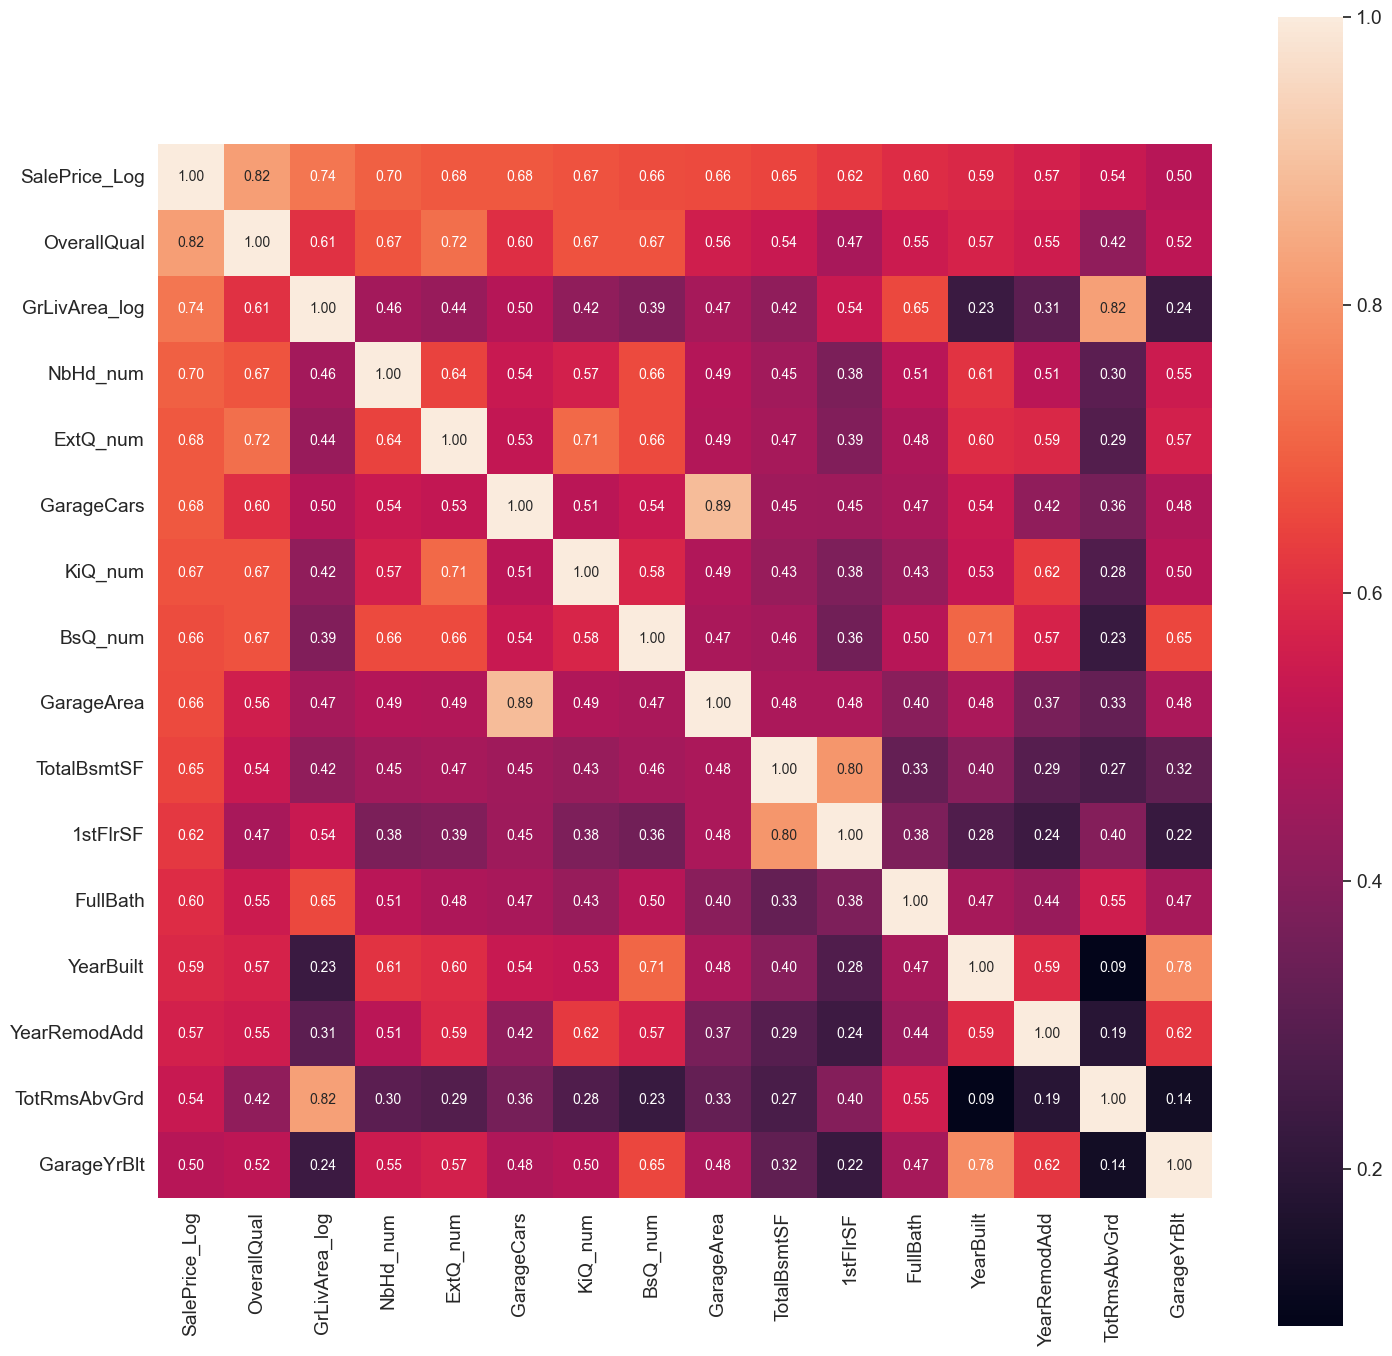

In [61]:
nr_feats = len(df_train.columns)
plot_corr_matrix(numm_3, nr_feats, target)

**Check for Multicollinearity**

Strong correlation of these features to other, similar features:

'GrLivArea_Log' and 'TotRmsAbvGrd'

'GarageCars' and 'GarageArea'

'TotalBsmtSF' and '1stFlrSF'

'YearBuilt' and 'GarageYrBlt'

**Of those features we drop the one that has smaller correlation coeffiecient to Target.**

In [62]:
cols = corr_abs.nlargest(nr_all_cols, target)[target].index
cols = list(cols)

if drop_similar == 1 :
    for col in ['GarageArea','1stFlrSF','TotRmsAbvGrd','GarageYrBlt'] :
        if col in cols: 
            cols.remove(col)

In [63]:
cols = list(cols)
print(cols)

['SalePrice_Log', 'OverallQual', 'GrLivArea_log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']


### List of features used for the Regressor in Part 3

In [64]:
feats = cols.copy()
feats.remove('SalePrice_Log')

print(feats)

['OverallQual', 'GrLivArea_log', 'NbHd_num', 'ExtQ_num', 'GarageCars', 'KiQ_num', 'BsQ_num', 'TotalBsmtSF', 'FullBath', 'YearBuilt', 'YearRemodAdd']


In [65]:
df_train_ml = df_train[feats].copy()
df_test_ml  = df_test[feats].copy()

y = df_train[target]

**Combine train and test data**  
for one hot encoding (use pandas get dummies) of all categorical features  
uncommenting the following cell increases the number of features  
up to now, all models in Part 3 are optimized for not applying one hot encoder  
when applied, GridSearchCV needs to be rerun

In [66]:
"""
all_data = pd.concat((df_train[feats], df_test[feats]))

li_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',
                  'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']
all_data = pd.get_dummies(all_data, columns=li_get_dummies, drop_first=True)

df_train_ml = all_data[:df_train.shape[0]]
df_test_ml  = all_data[df_train.shape[0]:]
"""

"\nall_data = pd.concat((df_train[feats], df_test[feats]))\n\nli_get_dummies = ['OverallQual', 'NbHd_num', 'GarageCars','ExtQ_num', 'KiQ_num',\n                  'BsQ_num', 'FullBath', 'Fireplaces', 'MSZ_num']\nall_data = pd.get_dummies(all_data, columns=li_get_dummies, drop_first=True)\n\ndf_train_ml = all_data[:df_train.shape[0]]\ndf_test_ml  = all_data[df_train.shape[0]:]\n"

### Standard Scaler

In [68]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
df_train_ml_sc = sc.fit_transform(df_train_ml)
df_test_ml_sc = sc.transform(df_test_ml)

In [69]:
df_train_ml_sc = pd.DataFrame(df_train_ml_sc)
df_train_ml_sc.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975


**Creating DataSets for ML Algorithm**

In [70]:
X = df_train_ml.copy()
y = df_train[target]
X_test = df_test_ml.copy()

X_sc = df_train_ml_sc.copy()
y_sc = df_train[target]
X_test_sc = df_test_ml_sc.copy()

X.info()
X_test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1458 entries, 0 to 1459
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1458 non-null   int64  
 1   GrLivArea_log  1458 non-null   float64
 2   NbHd_num       1458 non-null   int64  
 3   ExtQ_num       1458 non-null   int64  
 4   GarageCars     1458 non-null   int64  
 5   KiQ_num        1458 non-null   int64  
 6   BsQ_num        1458 non-null   int64  
 7   TotalBsmtSF    1458 non-null   int64  
 8   FullBath       1458 non-null   int64  
 9   YearBuilt      1458 non-null   int64  
 10  YearRemodAdd   1458 non-null   int64  
dtypes: float64(1), int64(10)
memory usage: 136.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1459 entries, 0 to 1458
Data columns (total 11 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   OverallQual    1459 non-null   int64  
 1   GrLivArea_log  1459 non-null 

In [71]:
X.head()

,OverallQual,GrLivArea_log,NbHd_num,ExtQ_num,GarageCars,KiQ_num,BsQ_num,TotalBsmtSF,FullBath,YearBuilt,YearRemodAdd
0,7,7.444249,2,3,2,3,2,856,2,2003,2003
1,6,7.140453,2,2,2,2,2,1262,2,1976,1976
2,7,7.487734,2,3,2,3,2,920,2,2001,2002
3,7,7.448334,2,2,3,3,1,756,1,1915,1970
4,8,7.695303,3,3,3,3,2,1145,2,2000,2000


In [72]:
X_sc.head()

,0,1,2,3,4,5,6,7,8,9,10
0,0.658506,0.539624,0.658963,1.061109,0.313159,0.741127,0.648281,-0.473766,0.793546,1.052959,0.880362
1,-0.068293,-0.380198,0.658963,-0.689001,0.313159,-0.770150,0.648281,0.504925,0.793546,0.158428,-0.428115
2,0.658506,0.671287,0.658963,1.061109,0.313159,0.741127,0.648281,-0.319490,0.793546,0.986698,0.831900
3,0.658506,0.551993,0.658963,-0.689001,1.652119,0.741127,-0.921808,-0.714823,-1.025620,-1.862551,-0.718888
4,1.385305,1.299759,2.162512,1.061109,1.652119,0.741127,0.648281,0.222888,0.793546,0.953567,0.734975


# Part 3: Scikit-learn Basic Regression models and comparison of results

**Test simple sklearn models and compare by metrics**

**We test the following Regressors from scikit-learn:** <br>
LinearRegression <br>
Ridge <br>
Lasso <br>
Elastic Net <br>
Stochastic Gradient Descent <br>
DecisionTreeRegressor <br>
RandomForestRegressor <br>
SVR 

**Model tuning and selection with GridSearchCV**


In [73]:
from sklearn.model_selection import GridSearchCV
score_calc = 'neg_mean_squared_error'

### Linear Regression

In [77]:
from sklearn.linear_model import LinearRegression

linreg = LinearRegression()
parameters = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'positive': [True, False]  # Whether to constrain the coefficients to be positive
}
grid_linear = GridSearchCV(linreg, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_linear.fit(X, y)

sc_linear = get_best_score(grid_linear)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.1505701269279893
{'fit_intercept': True, 'positive': False}
LinearRegression()


In [78]:
linreg_sc = LinearRegression()
parameters = {
    'fit_intercept': [True, False],  # Whether to calculate the intercept for this model
    'positive': [True, False]  # Whether to constrain the coefficients to be positive
}
grid_linear_sc = GridSearchCV(linreg_sc, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_linear_sc.fit(X_sc, y)

sc_linear_sc = get_best_score(grid_linear_sc)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
0.15057012692798993
{'fit_intercept': True, 'positive': False}
LinearRegression()


In [79]:
lineregr_all = LinearRegression()

lineregr_all.fit(X, y)
pred_linreg_all = lineregr_all.predict(X_test)
pred_linreg_all[pred_linreg_all < 0] = pred_linreg_all.mean()

In [80]:
sub_linreg = pd.DataFrame()
sub_linreg['Id'] = id_test
sub_linreg['SalePrice'] = pred_linreg_all

In [81]:
sub_linreg.head()

,Id,SalePrice
0,1461,11.573825
1,1462,11.936290
2,1463,12.046798
3,1464,12.140639
4,1465,12.288211


### Ridge

In [85]:
from sklearn.linear_model import Ridge

ridge = Ridge()
parameters = {
    'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1],  # Regularization strength
    'tol': [1e-06, 5e-06, 1e-05, 5e-05]  # Tolerance for stopping criterion
}

grid_ridge = GridSearchCV(ridge, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

# Get the best parameters
best_params_ridge = grid_ridge.best_params_

# Instantiate Ridge regression model with the best parameters and fit to the data
best_ridge = Ridge(**best_params_ridge)
best_ridge.fit(X, y)

sc_ridge = get_best_score(grid_ridge)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.15056874969043754
{'alpha': 0.5, 'tol': 1e-06}
Ridge(alpha=0.5, tol=1e-06)
0.15056874969043754
{'alpha': 0.5, 'tol': 1e-06}
Ridge(alpha=0.5, tol=1e-06)


In [86]:
ridge_sc = Ridge()
parameters = {
    'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1],  # Regularization strength
    'tol': [1e-06, 5e-06, 1e-05, 5e-05]  # Tolerance for stopping criterion
}
grid_ridge_sc = GridSearchCV(ridge_sc, parameters, cv=nr_cv, verbose=1, scoring = score_calc)
grid_ridge_sc.fit(X_sc, y)

sc_ridge_sc = get_best_score(grid_ridge_sc)

Fitting 5 folds for each of 24 candidates, totalling 120 fits
0.15056684767083628
{'alpha': 1, 'tol': 1e-06}
Ridge(alpha=1, tol=1e-06)


In [87]:
pred_ridge_all = grid_ridge.predict(X_test)

### Lasso

In [89]:
from sklearn.linear_model import Lasso

lasso = Lasso()
parameters = {
    'alpha': [0.001, 0.005, 0.01, 0.1, 0.5, 1],  # Regularization strength
    'tol': [1e-06, 5e-06, 1e-05, 5e-05]  # Tolerance for stopping criterion
}
grid_lasso = GridSearchCV(lasso, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_lasso.fit(X, y)

sc_lasso = get_best_score(grid_lasso)

pred_lasso = grid_lasso.predict(X_test)

Fitting 5 folds for each of 24 candidates, totalling 120 fits


0.15070834812114697
{'alpha': 0.001, 'tol': 5e-05}
Lasso(alpha=0.001, tol=5e-05)


### Elastic Net

In [91]:
from sklearn.linear_model import ElasticNet

enet = ElasticNet()
parameters = {
    'alpha': [0.1, 1.0, 10],  # Regularization strength
    'max_iter': [1000000],  # Maximum number of iterations for optimization
    'l1_ratio': [0.04, 0.05],  # L1 ratio (mixing parameter); 0.0 is L2 penalty, 1.0 is L1 penalty
    'fit_intercept': [False, True],  # Whether to calculate the intercept for this model
    'tol': [1e-02, 1e-03, 1e-04]  # Tolerance for stopping criterion
}
grid_enet = GridSearchCV(enet, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_enet.fit(X_sc, y_sc)

sc_enet = get_best_score(grid_enet)

pred_enet = grid_enet.predict(X_test_sc)

Fitting 5 folds for each of 36 candidates, totalling 180 fits


0.1520522055514401
{'alpha': 0.1, 'fit_intercept': True, 'l1_ratio': 0.04, 'max_iter': 1000000, 'tol': 0.01}
ElasticNet(alpha=0.1, l1_ratio=0.04, max_iter=1000000, tol=0.01)


### SGDRegressor

Linear model fitted by minimizing a regularized empirical loss with SGD. SGD stands for Stochastic Gradient Descent: the gradient of the loss is estimated each sample at a time and the model is updated along the way with a decresing strength schedule (aka learning rate). The regularizer is a penalty added to the loss function that shrinks model parameters towards the zero vector using either the squared euclidean norm L2 or the absolute norm L1 or a combination of both (Elastic Net).

In [92]:
from sklearn.linear_model import SGDRegressor

sgd = SGDRegressor()
parameters = {'max_iter' :[10000], 'alpha':[1e-05], 'epsilon':[1e-02], 'fit_intercept' : [True]  }
grid_sgd = GridSearchCV(sgd, parameters, cv=nr_cv, verbose=1, scoring=score_calc)
grid_sgd.fit(X_sc, y_sc)

sc_sgd = get_best_score(grid_sgd)

pred_sgd = grid_sgd.predict(X_test_sc)

Fitting 5 folds for each of 1 candidates, totalling 5 fits
0.1508814071038926
{'alpha': 1e-05, 'epsilon': 0.01, 'fit_intercept': True, 'max_iter': 10000}
SGDRegressor(alpha=1e-05, epsilon=0.01, max_iter=10000)


### DecisionTreeRegressor

In [94]:
from sklearn.tree import DecisionTreeRegressor

param_grid = {
    'max_depth': [7, 8, 9, 10],  # Maximum depth of the tree
    'max_features': [11, 12, 13, 14],  # Number of features to consider for the best split
    'max_leaf_nodes': [None, 12, 15, 18, 20],  # Grow trees with max_leaf_nodes in best-first fashion
    'min_samples_split': [20, 25, 30],  # The minimum number of samples required to split an internal node
    'random_state': [5]  # Seed used by the random number generator
}
grid_dtree = GridSearchCV(DecisionTreeRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring=score_calc)
grid_dtree.fit(X, y)

sc_dtree = get_best_score(grid_dtree)

pred_dtree = grid_dtree.predict(X_test)

Fitting 5 folds for each of 240 candidates, totalling 1200 fits


0.18569789815478105
{'max_depth': 8, 'max_features': 11, 'max_leaf_nodes': None, 'min_samples_split': 20, 'random_state': 5}
DecisionTreeRegressor(max_depth=8, max_features=11, min_samples_split=20,
                      random_state=5)


In [95]:
dtree_pred = grid_dtree.predict(X_test)
sub_dtree = pd.DataFrame()
sub_dtree['Id'] = id_test
sub_dtree['SalePrice'] = dtree_pred

In [96]:
sub_dtree.head()

,Id,SalePrice
0,1461,11.672907
1,1462,11.890306
2,1463,12.050555
3,1464,12.336892
4,1465,12.169403


### RandomForestRegressor

In [97]:
from sklearn.ensemble import RandomForestRegressor

param_grid = {'min_samples_split' : [3,4,6,10], 'n_estimators' : [70,100], 'random_state': [5] }
grid_rf = GridSearchCV(RandomForestRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_rf.fit(X, y)

sc_rf = get_best_score(grid_rf)

Fitting 5 folds for each of 8 candidates, totalling 40 fits
0.15145208750889852
{'min_samples_split': 6, 'n_estimators': 100, 'random_state': 5}
RandomForestRegressor(min_samples_split=6, random_state=5)


In [98]:
pred_rf = grid_rf.predict(X_test)

sub_rf = pd.DataFrame()
sub_rf['Id'] = id_test
sub_rf['SalePrice'] = pred_rf 

if use_logvals == 1:
    sub_rf['SalePrice'] = np.exp(sub_rf['SalePrice']) 

sub_rf.to_csv('rf.csv',index=False)

In [99]:
sub_rf.head(10)

,Id,SalePrice
0,1461,118716.227780
1,1462,134819.470687
2,1463,175478.869241
3,1464,190118.617809
4,1465,201252.270879
5,1466,181848.041429
6,1467,165168.129780
7,1468,179812.673975
8,1469,184864.523762
9,1470,117472.739031


### KNN Regressor

In [100]:
from sklearn.neighbors import KNeighborsRegressor

param_grid = {'n_neighbors' : [3,4,5,6,7,10,15] ,    
              'weights' : ['uniform','distance'] ,
              'algorithm' : ['ball_tree', 'kd_tree', 'brute']}

grid_knn = GridSearchCV(KNeighborsRegressor(), param_grid, cv=nr_cv, refit=True, verbose=1, scoring = score_calc)
grid_knn.fit(X_sc, y_sc)

sc_knn = get_best_score(grid_knn)

Fitting 5 folds for each of 42 candidates, totalling 210 fits
0.1600296326714359
{'algorithm': 'kd_tree', 'n_neighbors': 10, 'weights': 'distance'}
KNeighborsRegressor(algorithm='kd_tree', n_neighbors=10, weights='distance')


In [101]:
pred_knn = grid_knn.predict(X_test_sc)

sub_knn = pd.DataFrame()
sub_knn['Id'] = id_test
sub_knn['SalePrice'] = pred_knn

if use_logvals == 1:
    sub_knn['SalePrice'] = np.exp(sub_knn['SalePrice']) 

sub_knn.to_csv('knn.csv',index=False)

In [102]:
sub_knn.head(10)

,Id,SalePrice
0,1461,114421.160840
1,1462,135320.384103
2,1463,177765.871712
3,1464,198358.375492
4,1465,203791.633101
5,1466,181688.092765
6,1467,176380.605106
7,1468,177563.091453
8,1469,175822.505380
9,1470,117229.562595


GaussianProcessRegressor

In [103]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import DotProduct, ConstantKernel

gpr = GaussianProcessRegressor(random_state=5, alpha=5e-9, 
                                n_restarts_optimizer=0, 
                               optimizer='fmin_l_bfgs_b', 
                               copy_X_train=True)

param_grid = {'normalize_y' : [True,False],
              'kernel' : [DotProduct(), ConstantKernel(1.0, (1e-3, 1e3))] }

grid_gpr = GridSearchCV(gpr, param_grid, cv=nr_cv, verbose=1, scoring = score_calc)
grid_gpr.fit(X_sc, y_sc)

sc_gpr = get_best_score(grid_gpr)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


C:\Users\cW\AppData\Roaming\Python\Python39\site-packages\sklearn\gaussian_process\_gpr.py:659: ConvergenceWarning: lbfgs failed to converge (status=2):
ABNORMAL_TERMINATION_IN_LNSRCH.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  _check_optimize_result("lbfgs", opt_res)
C:\Users\cW\AppData\Roaming\Python\Python39\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn(
C:\Users\cW\AppData\Roaming\Python\Python39\site-packages\sklearn\gaussian_process\kernels.py:419: ConvergenceWarning: The optimal value found for dimension 0 of parameter constant_value is close to the specified lower bound 0.001. Decreasing the bound and calling fit again may find a better value.
  warnings.warn

0.15057013577418668
{'kernel': DotProduct(sigma_0=1), 'normalize_y': True}
GaussianProcessRegressor(alpha=5e-09, kernel=DotProduct(sigma_0=1),
                         normalize_y=True, random_state=5)


In [104]:
pred_gpr = grid_gpr.predict(X_test_sc)

sub_gpr = pd.DataFrame()
sub_gpr['Id'] = id_test
sub_gpr['SalePrice'] = pred_gpr

if use_logvals == 1:
    sub_gpr['SalePrice'] = np.exp(sub_gpr['SalePrice']) 

sub_gpr.to_csv('gpr.csv',index=False)

#### Comparison Plot: RMSE of all Models

In [105]:
list_scores = [sc_linear, sc_ridge, sc_lasso, sc_enet,
               sc_sgd, sc_dtree, sc_rf, sc_knn, sc_gpr]
list_regressors = ['Linear','Ridge','Lasso','ElaNet','SGD','DTr','RF','KNN','GPR']

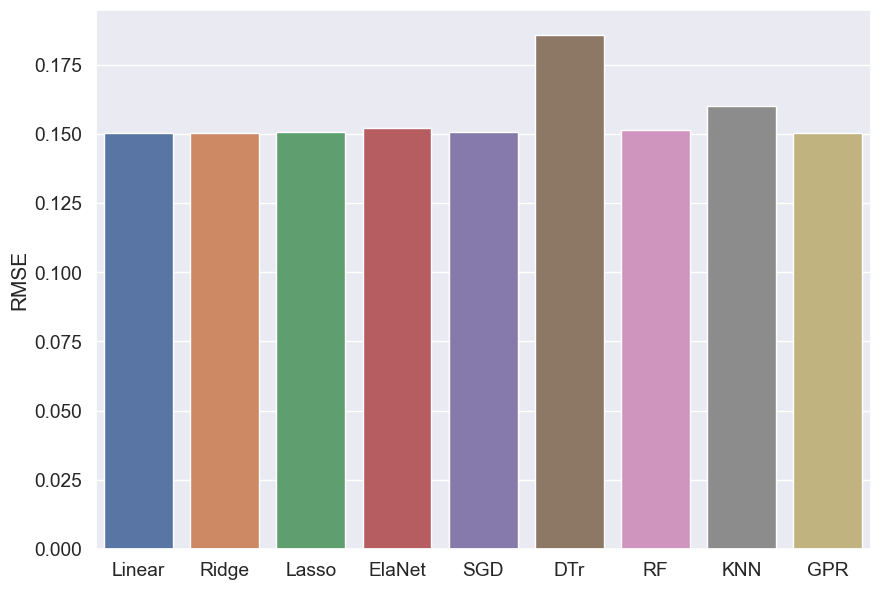

In [106]:
fig, ax = plt.subplots()
fig.set_size_inches(10,7)
sns.barplot(x=list_regressors, y=list_scores, ax=ax)
plt.ylabel('RMSE')
plt.show()

The performance of all applied Regressors is very similar, except for Decision Tree which has larger RMSE than the other models.

#### Correlation of Model Results

In [107]:
predictions = {'Linear': pred_linreg_all, 'Ridge': pred_ridge_all, 'Lasso': pred_lasso,
               'ElaNet': pred_enet, 'SGD': pred_sgd, 'DTr': pred_dtree, 'RF': pred_rf,
               'KNN': pred_knn, 'GPR': pred_gpr}
df_predictions = pd.DataFrame(data=predictions) 
df_predictions.corr()

,Linear,Ridge,Lasso,ElaNet,SGD,DTr,RF,KNN,GPR
Linear,1.000000,0.999998,0.999820,0.998695,0.999864,0.947962,0.974279,0.965206,1.000000
Ridge,0.999998,1.000000,0.999847,0.998766,0.999839,0.947995,0.974321,0.965357,0.999998
Lasso,0.999820,0.999847,1.000000,0.999214,0.999543,0.948338,0.974622,0.965871,0.999820
ElaNet,0.998695,0.998766,0.999214,1.000000,0.998211,0.947144,0.973757,0.968648,0.998695
SGD,0.999864,0.999839,0.999543,0.998211,1.000000,0.947550,0.973875,0.964224,0.999864
DTr,0.947962,0.947995,0.948338,0.947144,0.947550,1.000000,0.972033,0.936947,0.947962
RF,0.974279,0.974321,0.974622,0.973757,0.973875,0.972033,1.000000,0.970632,0.974279
KNN,0.965206,0.965357,0.965871,0.968648,0.964224,0.936947,0.970632,1.000000,0.965206
GPR,1.000000,0.999998,0.999820,0.998695,0.999864,0.947962,0.974279,0.965206,1.000000


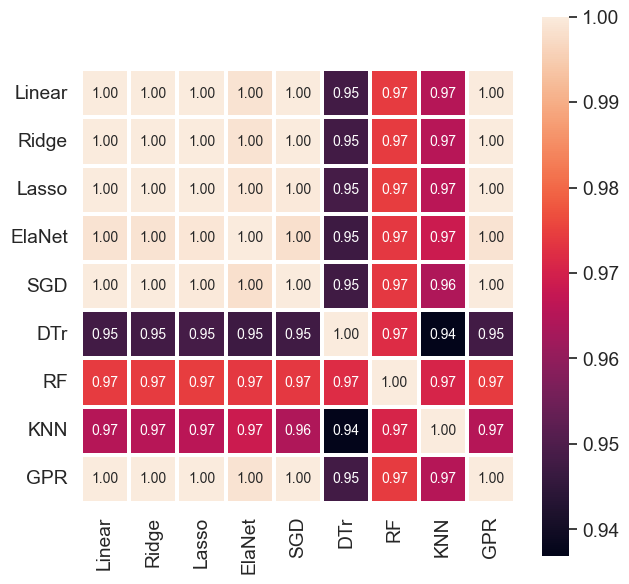

In [108]:
plt.figure(figsize=(7, 7))
sns.set(font_scale=1.25)
sns.heatmap(df_predictions.corr(), linewidths=1.5, annot=True, square=True, 
                fmt='.2f', annot_kws={'size': 10}, 
                yticklabels=df_predictions.columns , xticklabels=df_predictions.columns
            )
plt.show()

For the first five models, the predictions show a very high correlation to each other (very close to 1.00).  
Only for Random Forest and Decision Tree, the results  are less correlated with the other Regressors. 

In [109]:
sub_mean = pd.DataFrame()
sub_mean['Id'] = id_test
sub_mean['SalePrice'] = np.round( (pred_lasso + pred_enet + pred_rf + pred_sgd) / 4.0 ) 
sub_mean['SalePrice'] = sub_mean['SalePrice'].astype(float)
sub_mean.to_csv('mean.csv',index=False)

# FIN!